# Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For datetime
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load CSV into dataframe

In [41]:
sales = pd.read_csv("Sales_Dataset.csv", encoding='latin1')
production_recipe = pd.read_csv("production_recipe.csv", encoding='latin1')

# Preprocessing

In [42]:
# Remove whitespace and normalize column names to snake_case
#SALES
sales.columns = (
    sales.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.lower()
)

# PRODUCTION
production_recipe.columns = (
    production_recipe.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.lower()
)

# Sales
sales = sales[
    [
    'system_date',
    'food_id',
    'dish_name',
    'production_food_name',
    'quantity',
    'total_price',
    'food_cost'
    ]
]
# Convert date columns - fixing the date format issue by specifying dayfirst=True
sales['system_date'] = pd.to_datetime(sales['system_date'], dayfirst=True)

# Production
# Fix typo
production_recipe.rename(columns={'ingredians': 'ingredients'}, inplace=True)

print(sales.columns)
print(production_recipe.columns)

Index(['system_date', 'food_id', 'dish_name', 'production_food_name',
       'quantity', 'total_price', 'food_cost'],
      dtype='object')
Index(['production_food_name', 'ingredients', 'quantity'], dtype='object')


# Margin metrics

In [43]:
# Margin metrics
if {'total_price', 'food_cost'}.issubset(sales.columns):
  #clean columns
    sales['total_price'] = sales['total_price'].astype(str).str.replace('$', '', regex=False).str.strip()
    sales['food_cost'] = sales['food_cost'].astype(str).str.replace('$', '', regex=False).str.strip()
  #convert columns to numeric values
    sales['total_price'] = pd.to_numeric(sales['total_price'], errors='coerce')
    sales['food_cost'] = pd.to_numeric(sales['food_cost'], errors='coerce')
  #add calculation
    sales['gross_margin'] = sales['total_price'] - sales['food_cost']
    sales['gross_margin_percent'] = (sales['gross_margin'] / sales['total_price']) * 100

# Sales data summary

In [44]:
print("Descriptive Statistics for Sales:")
print("\nTop 15 Dishes Sold:")
top_dishes = sales.groupby(['food_id', 'dish_name'])['quantity'].sum().sort_values(ascending=False).head(15)
print(top_dishes)

print("\nSales Columns")
print(sales.columns)
print("\nProduction Columns")
print(production_recipe.columns)

Descriptive Statistics for Sales:

Top 15 Dishes Sold:
food_id  dish_name                             
893      Strawberry Sunrise                        5965
1002     Creole Shrimp and Grits                   5046
894      Crispy Karma                              4919
1319     Southern Fried Catfish Po' Boy            4698
939      The Crispy Crunch Burger                  4319
1008     Sweet Tea-Brined Pork Chops               4243
963      The Philly Cheesesteak Inspired Burger    3706
1000     Peach Perfection                          3431
931      Delish Dhaba                              3200
1381     Cajun Jambalaya                           2554
910      Curry Chronicles                          2372
940      Saffron Symphony                          2323
946      The Spicy Sriracha Kick Burger            2280
930      Epic Flavor Quest                         2179
1311     Banana Pudding                            2163
Name: quantity, dtype: int64

Sales Columns
Index(['syste

### Merge sale data with production recipe to get ingredient demand per sale

In [45]:
# Step 1: Merge sales with production_recipe to get ingredient-level demand per sale
merged = pd.merge(
    sales,
    production_recipe,
    on="production_food_name",
    how="inner",
    suffixes=("_sale", "_production")
)
# Step 2: Calculate total ingredient demand per sale row
# Each sale row now has a 'quantity' (dishes sold) and a 'quantity_y' (ingredient amount per dish)
merged['ingredient_total_qty'] = merged['quantity_sale'] * merged['quantity_production']
# Step 3: Aggregate total demand for each ingredient
ingredient_demand = (
    merged
    .groupby('ingredients')['ingredient_total_qty']
    .sum()
    .reset_index(name='total_demand')
    .sort_values('total_demand',ascending=False)
)

# Step 4: Display the result
print(ingredient_demand.head(10))


#check in order of RM Name
ingredient_demand['RM Code'] = (
    ingredient_demand['ingredients']
    .str.extract(r'(\d+)$')
    .astype(int)
)
ingredient_demand_sorted = ingredient_demand.sort_values('RM Code')
print(ingredient_demand_sorted.head(10))

    ingredients  total_demand
74   RM Name 55   65695942.92
112   RM Name 9   32469605.79
59   RM Name 41   31843050.00
122  RM Name 99   28458000.00
23   RM Name 12   25027710.00
63   RM Name 45   24513821.69
1    RM Name 10   21283690.00
79    RM Name 6   16480574.00
90    RM Name 7   11046729.18
34   RM Name 19    7388593.18
    ingredients  total_demand  RM Code
0     RM Name 1     779040.00        1
35    RM Name 2    1228765.10        2
46    RM Name 3      19316.00        3
57    RM Name 4      19316.00        4
68    RM Name 5    2398083.47        5
79    RM Name 6   16480574.00        6
90    RM Name 7   11046729.18        7
101   RM Name 8    6918264.53        8
112   RM Name 9   32469605.79        9
1    RM Name 10   21283690.00       10


### Get daily ingredient demand

In [46]:
restaurant_daily_ingredient_demand = (
    merged
    .groupby([
        pd.Grouper(key='system_date', freq='D'),
        'ingredients',
        ])['ingredient_total_qty']
    .sum()
    .reset_index()
)

restaurant_daily_ingredient_demand.head()

,system_date,ingredients,ingredient_total_qty
0,2024-01-01,RM Name 1,480.0
1,2024-01-01,RM Name 10,48540.0
2,2024-01-01,RM Name 100,500.0
3,2024-01-01,RM Name 102,5000.0
4,2024-01-01,RM Name 103,300.0


### Apply 5% wastage rate to daily ingredient demand

In [47]:
wastage_rate = 0.05
restaurant_daily_ingredient_demand['ingredient_total_qty_adj'] = (
    restaurant_daily_ingredient_demand['ingredient_total_qty']
    * (1 + wastage_rate)
)

# Summarize the impact of wastage adjustment by ingredient
adj_summary = (
    restaurant_daily_ingredient_demand
    .groupby('ingredients')['ingredient_total_qty_adj']
    .sum()
    .reset_index(name='total_demand_with_wastage')
)
print("Total Adjusted Ingredient Demand by Type (with 5% wastage):")
print(adj_summary)

#Check the scale factor of RM Name 1
rm1 = restaurant_daily_ingredient_demand[
    restaurant_daily_ingredient_demand['ingredients'] == 'RM Name 1'
]
orig_sum = rm1['ingredient_total_qty'].sum()
adj_sum  = rm1['ingredient_total_qty_adj'].sum()

# Print both and the ratio
print(f"RM Name 1 — Original: {orig_sum:.2f}, Adjusted: {adj_sum:.2f}, Ratio: {adj_sum/orig_sum:.4f}")

Total Adjusted Ingredient Demand by Type (with 5% wastage):
     ingredients  total_demand_with_wastage
0      RM Name 1               8.179920e+05
1     RM Name 10               2.234787e+07
2    RM Name 100               2.490075e+05
3    RM Name 101               3.528000e+03
4    RM Name 102               1.737750e+06
..           ...                        ...
118   RM Name 95               1.018500e+05
119   RM Name 96               1.782375e+04
120   RM Name 97               2.053800e+06
121   RM Name 98               1.611203e+05
122   RM Name 99               2.988090e+07

[123 rows x 2 columns]
RM Name 1 — Original: 779040.00, Adjusted: 817992.00, Ratio: 1.0500


# Exploratory Analysis

### Ingredient Usage Trends --> Time Series Plot

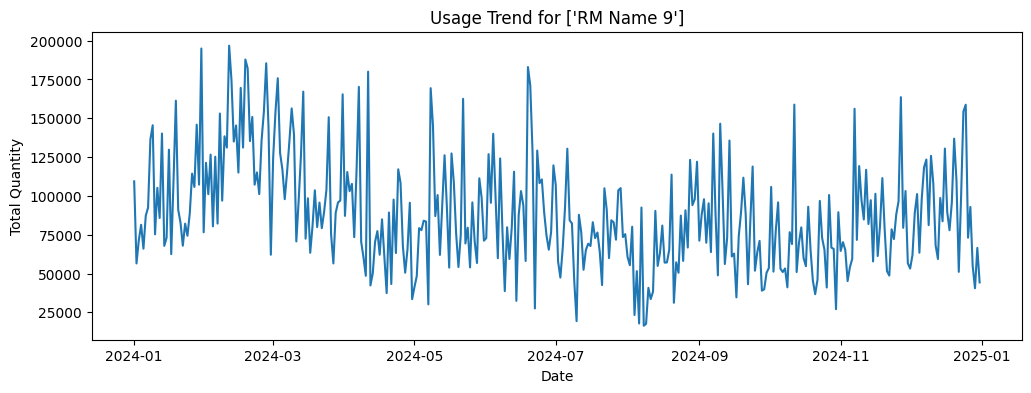

In [48]:
# Plot total ingredient demand over time for a selected ingredient
ingredient_name = ['RM Name 9']
trend = (
    restaurant_daily_ingredient_demand
    .loc[restaurant_daily_ingredient_demand['ingredients'].isin(ingredient_name)]
    .groupby('system_date')['ingredient_total_qty']
    .sum()
    .reset_index())
plt.figure(figsize=(12, 4))
plt.plot(trend['system_date'], trend['ingredient_total_qty'])
plt.title(f"Usage Trend for {ingredient_name}")
plt.xlabel("Date")
plt.ylabel("Total Quantity")
plt.show()

### Dish-to-ingredient Mapping

In [49]:
# Map which dishes use a specific ingredient
ingredient_name = 'RM Name 9'

# Find all dishes that use that ingredient in production
food_withRM = production_recipe.loc[
    production_recipe['ingredients']==ingredient_name,
    'production_food_name'
].unique()

#find all the dishes that use that food_name in sales
dish_withRM = (
    sales[sales['production_food_name'].isin(food_withRM)]
    [['food_id','production_food_name','dish_name']]
    .drop_duplicates(subset=['production_food_name'], keep='first')
)

#display results
print(f"Dishes using {ingredient_name}:")
display(dish_withRM.head(15))

Dishes using RM Name 9:


,food_id,production_food_name,dish_name
3,1010,Production Food Name 2,Pimento Cheese-Stuffed Jalapeno Poppers
6,1006,Production Food Name 5,Southern Fried Green Tomatoes
105,1371,Production Food Name 13,Slow-Cooked Pulled Pork
760,920,Production Food Name 17,Chaat Carnival
761,928,Production Food Name 18,Artisanal Appetites
883,921,Production Food Name 20,Caramel Macchiato Delight
1044,917,Production Food Name 21,Blue Lagoon Mocktail
1345,922,Production Food Name 35,Savory Spell
1662,946,Production Food Name 42,The Spicy Sriracha Kick Burger
2118,965,Production Food Name 49,The Tangy Teriyaki Pineapple Burger


### Outlier Detection

In [50]:
# Identify days with unusually high ingredient usage (e.g., z-score > 3)
from scipy.stats import zscore
restaurant_daily_ingredient_demand['zscore'] = restaurant_daily_ingredient_demand.groupby('ingredients')['ingredient_total_qty'].transform(zscore)
outliers = restaurant_daily_ingredient_demand[restaurant_daily_ingredient_demand['zscore'].abs() > 3]
print(outliers[['system_date', 'ingredients', 'ingredient_total_qty', 'zscore']])

      system_date  ingredients  ingredient_total_qty    zscore
51     2024-01-01   RM Name 40                7500.0  3.737355
52     2024-01-01   RM Name 41              199575.0  3.050441
55     2024-01-01   RM Name 44               24801.5  3.542240
66     2024-01-01   RM Name 54                2004.0  4.876466
68     2024-01-01   RM Name 56               55025.0  4.506961
...           ...          ...                   ...       ...
38360  2024-12-22   RM Name 46                2200.0  5.763172
38430  2024-12-23  RM Name 114               46940.0  3.805901
38530  2024-12-24  RM Name 112               56825.0  3.717810
38807  2024-12-26   RM Name 69                2000.0  3.214550
38809  2024-12-26   RM Name 70                1000.0  3.214550

[476 rows x 4 columns]


### Visualization --> Heatmap

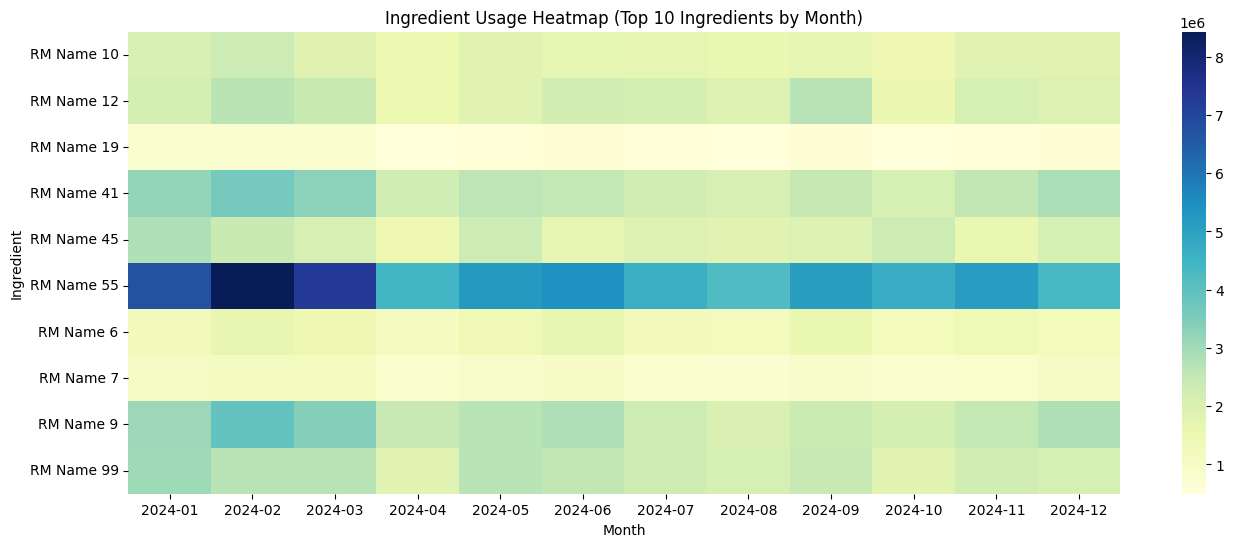

In [51]:
# Add a new column for month for example '2025-06'
restaurant_daily_ingredient_demand['month'] = restaurant_daily_ingredient_demand['system_date'].dt.to_period('M').astype(str)

# Get top 10 ingredients by total demand
top_ingredients = ingredient_demand.sort_values('total_demand', ascending=False).head(10)['ingredients']

# Filter and pivot by month instead of date
heatmap_data = restaurant_daily_ingredient_demand[
    restaurant_daily_ingredient_demand['ingredients'].isin(top_ingredients)
].pivot_table(
    index='month',
    columns='ingredients',
    values='ingredient_total_qty',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data.T, annot=False, cmap="YlGnBu")
plt.title("Ingredient Usage Heatmap (Top 10 Ingredients by Month)")
plt.xlabel("Month")
plt.ylabel("Ingredient")
plt.show()

# Cost Analysis

### Cost per ingredient

In [52]:
# 1. Merge food_cost from sales into production_recipe
# Only keep unique production_food_name & food_cost combinations
sales_cost = (
    sales[['production_food_name', 'food_cost']]
    .drop_duplicates()
    )

# Merge
recipe_with_cost = (
    production_recipe.merge(
    sales_cost,
    on='production_food_name',
    how='left')
)

# 2. Calculate the total quantity of all ingredients for each production_food_name
recipe_with_cost['total_recipe_quantity'] = (
    recipe_with_cost.groupby('production_food_name')['quantity'].transform('sum')
)

# 3. Calculate the share of each ingredient in its recipe
recipe_with_cost['ingredient_share'] = (
    recipe_with_cost['quantity'] / recipe_with_cost['total_recipe_quantity']
)

# 4. Allocate the food cost to each ingredient (share * total cost)
recipe_with_cost['food_cost'] = recipe_with_cost['food_cost'].astype(float)
recipe_with_cost['ingredient_cost'] = (
    recipe_with_cost['ingredient_share'] * recipe_with_cost['food_cost']
)

# 5. Create the final DataFrame for model training by getting the sum of total cost of every ingredient
#and computing the average as the final cost value for cleaner data
ingredient_total_cost_df = (
    recipe_with_cost
    .groupby('ingredients')['ingredient_cost']
    .mean()
    .reset_index()
    .rename(columns={'ingredients': 'ingredient_RM', 'ingredient_cost': 'total_cost'})
    .sort_values('total_cost', ascending=False)
)

# Dispaly
display(ingredient_total_cost_df)


# display in order of ingredient
ingredient_total_cost_df['rm_number'] = (
    ingredient_total_cost_df['ingredient_RM']
    .str.extract(r'(\d+)')
    .astype(int)
    )

ingredient_total_cost_df_sorted = ingredient_total_cost_df.sort_values('rm_number').reset_index(drop=True)
display(ingredient_total_cost_df_sorted)

,ingredient_RM,total_cost
117,RM Name 94,0.099896
27,RM Name 123,0.084361
89,RM Name 69,0.076809
81,RM Name 61,0.071956
92,RM Name 71,0.060115
...,...,...
2,RM Name 100,0.000122
46,RM Name 3,0.000082
57,RM Name 4,0.000082
37,RM Name 21,0.000078


,ingredient_RM,total_cost,rm_number
0,RM Name 1,0.002679,1
1,RM Name 2,0.000976,2
2,RM Name 3,0.000082,3
3,RM Name 4,0.000082,4
4,RM Name 5,0.000893,5
...,...,...,...
118,RM Name 119,0.001694,119
119,RM Name 120,0.048388,120
120,RM Name 121,0.001376,121
121,RM Name 122,0.037024,122


### Demand, Supply, Revenue, and Profit Margin of every ingredient for every quarter

The calculations will be made over a 3 month period, assuming every quantity in production_recipe is the same because no dates were provided

This will be used to compute the revenue using the dates from sales

In [53]:
# ARRANGE INGREDIENTS BY QUARTER
# Create column in sales for every quarter
sales['quarter'] = pd.to_datetime(sales['system_date']).dt.to_period('Q')

# Get unique list of quarters in your sales data
quarters = sales['quarter'].unique()
ingredients = production_recipe['ingredients'].unique()

# Compute total supply of each ingredient for the 3-month period (from production_recipe)
# If you assume you produce the entire production_recipe each quarter:
supply_by_ingredient = (
    production_recipe
    .groupby('ingredients')['quantity']
    .sum()
    .reset_index()
    .rename(columns={'quantity': 'supply_quantity'})
    )

# Make a DataFrame with all ingredient/quarter combos
quarterly_supply = pd.MultiIndex.from_product([ingredients, quarters], names=['ingredients', 'quarter']).to_frame(index=False)
quarterly_supply = quarterly_supply.merge(supply_by_ingredient, on='ingredients', how='left')

# 1. Compute demand per ingredient per quarter from sales
# First, total units sold per product per quarter
units_sold_quarter = (
    sales
    .groupby(['production_food_name', 'quarter'])['quantity']
    .sum()
    .reset_index()
    .rename(columns={'quantity': 'units_sold'})
    )

# Merge with production_recipe to get total ingredient demand per product per quarter
ingredient_demand_quarter = (
    production_recipe
    .merge(units_sold_quarter, on='production_food_name', how='left')
)
ingredient_demand_quarter['total_demand'] = ingredient_demand_quarter['quantity'] * ingredient_demand_quarter['units_sold']

# Group to get total ingredient demand per ingredient per quarter
ingredient_total_demand_quarter = (
    ingredient_demand_quarter.groupby(['ingredients', 'quarter'])['total_demand']
    .sum().reset_index().rename(columns={'total_demand': 'ingredient_total_demand'})
)

# 2. Merge cost per ingredient
quarterly_profit_df = (
    quarterly_supply.merge(
        ingredient_total_cost_df[['ingredient_RM', 'total_cost']],
        left_on='ingredients',
        right_on='ingredient_RM',
        how='left'
    )
)

# 3. Merge in ingredient demand per quarter
quarterly_profit_df = quarterly_profit_df.merge(
    ingredient_total_demand_quarter,
    on=['ingredients', 'quarter'],
    how='left'
).fillna(0)

# 4. Allocate revenue per ingredient per quarter
# Re-calculate ingredient share from the recipe
production_recipe['total_recipe_quantity'] = production_recipe.groupby('production_food_name')['quantity'].transform('sum')
production_recipe['ingredient_share'] = production_recipe['quantity'] / production_recipe['total_recipe_quantity']

# Merge share into sales and calculate ingredient revenue for each sale/quarter
sales_ingredients = sales.merge(
    production_recipe[['production_food_name', 'ingredients', 'ingredient_share']],
    on='production_food_name', how='left'
)
sales_ingredients['quarter'] = pd.to_datetime(sales_ingredients['system_date']).dt.to_period('Q')
sales_ingredients['ingredient_revenue'] = sales_ingredients['ingredient_share'] * sales_ingredients['total_price']

# Sum up revenue per ingredient per quarter
ingredient_revenue_quarter = sales_ingredients.groupby(['ingredients', 'quarter'])['ingredient_revenue'].sum().reset_index()

# Merge revenue into quarterly_profit_df
quarterly_profit_df = quarterly_profit_df.merge(
    ingredient_revenue_quarter, on=['ingredients', 'quarter'], how='left'
).fillna(0)

# 5. Calculate profit/loss and surplus/shortage for each quarter
quarterly_profit_df['total_supply_cost'] = quarterly_profit_df['supply_quantity'] * quarterly_profit_df['total_cost']
quarterly_profit_df['total_demand_cost'] = quarterly_profit_df['ingredient_total_demand'] * quarterly_profit_df['total_cost']
quarterly_profit_df['profit'] = quarterly_profit_df['ingredient_revenue'] - quarterly_profit_df['total_demand_cost']
quarterly_profit_df['surplus_shortage'] = quarterly_profit_df['supply_quantity'] - quarterly_profit_df['ingredient_total_demand']
quarterly_profit_df['profit_margin'] = (quarterly_profit_df['profit'] / quarterly_profit_df['ingredient_revenue'].replace(0, pd.NA)) * 100

# 6. Display results
cols_to_display = [
    'ingredients', 'quarter', 'supply_quantity', 'ingredient_total_demand', 'surplus_shortage',
    'total_cost', 'total_supply_cost', 'total_demand_cost',
    'ingredient_revenue', 'profit', 'profit_margin'
]
quarterly_profit_df_sorted = quarterly_profit_df[cols_to_display].sort_values(
    ['quarter', 'profit'], ascending=[True, False]
)
quarterly_profit_df_sorted.head(20)

# 7. Export results
quarterly_profit_df.to_csv('quarterly_ingredient_data.csv', index=False)


# Using newly generated dataset

### Load dataset

In [54]:
df = pd.read_csv('quarterly_ingredient_data.csv')
df.head()

,ingredients,quarter,supply_quantity,ingredient_RM,total_cost,ingredient_total_demand,ingredient_revenue,total_supply_cost,total_demand_cost,profit,surplus_shortage,profit_margin
0,RM Name 1,2024Q1,120.00,RM Name 1,0.002679,189000.00,699.166449,0.321518,506.391474,192.774975,-188880.0,27.572115
1,RM Name 1,2024Q4,120.00,RM Name 1,0.002679,187320.00,642.806618,0.321518,501.890216,140.916402,-187200.0,21.922052
2,RM Name 1,2024Q2,120.00,RM Name 1,0.002679,195960.00,685.201385,0.321518,525.039541,160.161845,-195840.0,23.374419
3,RM Name 1,2024Q3,120.00,RM Name 1,0.002679,206760.00,724.365987,0.321518,553.976196,170.389791,-206640.0,23.522611
4,RM Name 2,2024Q1,2105.31,RM Name 2,0.000976,358128.51,2086.439849,2.055428,349.643291,1736.796558,-356023.2,83.242110


# Model Design

### Encoding, Feature Engineering and Training

In [55]:
!pip install xgboost==3.0.2

In [56]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Import pandas if not already imported

# 1. Sort and encode
df = df.sort_values(['ingredients', 'quarter'])
le = LabelEncoder()
df['ingredients_encoded'] = le.fit_transform(df['ingredients'])

# Convert 'quarter' from object to Period and then to a numerical format
# Assuming 'quarter' is in 'YYYYQn' format after reading the CSV
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')
df['quarter_encoded'] = df['quarter'].apply(lambda x: x.year * 4 + x.quarter)


# 2. Compute Exponential Smoothing forecast as a feature
df['es_forecast'] = np.nan
for ingr, group in df.groupby('ingredients'):
    group = group.sort_values('quarter')
    es_preds = []
    for i in range(len(group)):
        if i < 2:
            es_preds.append(np.nan)
        else:
            es = ExponentialSmoothing(
                group['supply_quantity'].iloc[:i],
                trend='add', seasonal=None, initialization_method="estimated"
            )
            es_fit = es.fit()
            es_forecast = es_fit.forecast(1).values[0]
            es_preds.append(es_forecast)
    df.loc[group.index, 'es_forecast'] = es_preds

print("ES forecasts added as feature.")

# 3. Choose features for the regression
features = [
    'ingredient_total_demand', 'profit', 'profit_margin', 'total_cost', 'ingredient_revenue',
    'es_forecast',
    'ingredients_encoded', 'quarter_encoded' # Use the new numerical quarter feature
]
target = 'supply_quantity'

# 4. Drop rows missing any values
df_model = df.dropna(subset=[target, 'es_forecast'] + features).copy()
X = df_model[features]
y = df_model[target]
groups = df_model['ingredients']

# 5. Cross-validation (by ingredient)
kf = GroupKFold(n_splits=5)
mae_scores = []
mae_pct_scores = []
all_preds = []

for train_idx, test_idx in kf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    # Removed enable_categorical as we converted 'quarter' to numerical
    model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    fold_mae = mean_absolute_error(y_test, preds)
    mean_actual = np.mean(y_test)
    fold_mae_pct = 100 * fold_mae / mean_actual if mean_actual != 0 else np.nan
    mae_scores.append(fold_mae)
    mae_pct_scores.append(fold_mae_pct)
    print(f"Fold MAE (XGB + ES feature): {fold_mae:.2f} units ({fold_mae_pct:.2f}% of mean actual supply)")

    # Save results
    fold_df = pd.DataFrame({
        'ingredient': df_model.iloc[test_idx]['ingredients'],
        'quarter': df_model.iloc[test_idx]['quarter'], # Keep the original quarter Period object for display
        'actual': y_test,
        'xgb_es_pred': preds,
        'es_forecast': X_test['es_forecast'],
        'ingredient_revenue': df_model.iloc[test_idx]['ingredient_revenue'],
        'total_cost': df_model.iloc[test_idx]['total_cost']
    })
    all_preds.append(fold_df)

# Combine all and save
preds_df = pd.concat(all_preds, ignore_index=True)
print("Computation complete.")

ES forecasts added as feature.
Fold MAE (XGB + ES feature): 1940.03 units (47.87% of mean actual supply)
Fold MAE (XGB + ES feature): 182.67 units (7.36% of mean actual supply)
Fold MAE (XGB + ES feature): 620.94 units (22.66% of mean actual supply)
Fold MAE (XGB + ES feature): 292.90 units (5.25% of mean actual supply)
Fold MAE (XGB + ES feature): 544.00 units (12.86% of mean actual supply)
Computation complete.


# Performance evaluation

### Actual vs. Predicted profit/loss

In [60]:
# Calculate and print profit/loss for predictions and actuals
preds_df['pred_profit'] = preds_df['ingredient_revenue'] - preds_df['xgb_es_pred'] * preds_df['total_cost']
preds_df['actual_profit'] = preds_df['ingredient_revenue'] - preds_df['actual'] * preds_df['total_cost']

preds_df['pred_loss'] = preds_df['pred_profit'].where(preds_df['pred_profit'] < 0, 0).abs()
preds_df['actual_loss'] = preds_df['actual_profit'].where(preds_df['actual_profit'] < 0, 0).abs()

total_pred_profit = preds_df['pred_profit'].where(preds_df['pred_profit'] > 0, 0).sum()
total_actual_profit = preds_df['actual_profit'].where(preds_df['actual_profit'] > 0, 0).sum()

total_pred_loss = preds_df['pred_loss'].sum()
total_actual_loss = preds_df['actual_loss'].sum()

print(f"Total predicted profit: {total_pred_profit:,.2f}")
print(f"Total actual profit:    {total_actual_profit:,.2f}")
print(f"Total predicted loss:   {total_pred_loss:,.2f}")
print(f"Total actual loss:      {total_actual_loss:,.2f}")

#Net profit - Calculate the sum of the net profit Series
net_pred_profit = (preds_df['pred_profit'] - preds_df['pred_loss']).sum()
net_actual_profit = (preds_df['actual_profit'] - preds_df['actual_loss']).sum()

print(f"Net predicted profit: {net_pred_profit:,.2f}")
print(f"Net actual profit:    {net_actual_profit:,.2f}")

Total predicted profit: 185,961.60
Total actual profit:    185,208.42
Total predicted loss:   770.18
Total actual loss:      832.79
Net predicted profit: 184,421.24
Net actual profit:    183,542.84


### Mean Absolute Error

In [61]:
mean_profit = preds_df['pred_profit'].mean()
mean_actual_profit = preds_df['actual_profit'].mean()
mean_loss = preds_df['pred_loss'].mean()
mean_actual_loss = preds_df['actual_loss'].mean()

print("\nModel Performance Across Folds")
print(f"Mean MAE: {np.mean(mae_scores):.2f} units")
print(f"Mean MAE (as % of mean supply): {np.mean(mae_pct_scores):.2f}%")
print(f"Average predicted profit: {mean_profit:,.2f}")
print(f"Average actual profit:    {mean_actual_profit:,.2f}")
print(f"Average predicted loss:   {mean_loss:,.2f}")
print(f"Average actual loss:      {mean_actual_loss:,.2f}")


Model Performance Across Folds
Mean MAE: 716.11 units
Mean MAE (as % of mean supply): 19.20%
Average predicted profit: 752.81
Average actual profit:    749.49
Average predicted loss:   3.13
Average actual loss:      3.39


### Most profitable vs Least profitable ingredient

In [62]:
print("\nTop 5 most profitable predictions:")
print(preds_df.sort_values('pred_profit', ascending=False).head(5)[['ingredient', 'quarter', 'pred_profit']])

print("\nTop 5 least profitable predictions:")
print(preds_df.sort_values('pred_profit').head(5)[['ingredient', 'quarter', 'pred_profit']])


Top 5 most profitable predictions:
     ingredient quarter   pred_profit
180   RM Name 6  2024Q3  11856.342075
181   RM Name 6  2024Q4  11148.929090
239  RM Name 81  2024Q4   8494.151107
238  RM Name 81  2024Q3   8160.059122
51   RM Name 10  2024Q4   7401.932874

Top 5 least profitable predictions:
      ingredient quarter  pred_profit
150  RM Name 102  2024Q3  -171.010169
151  RM Name 102  2024Q4  -117.895240
10   RM Name 123  2024Q3   -73.886265
184   RM Name 69  2024Q3   -61.244438
61   RM Name 122  2024Q4   -53.366422


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73d24530-0a42-43b8-bdfa-aff978f6aac1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>